# Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**

In [2]:
import math
from collections import Counter
from dataclasses import dataclass
import functools

import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.tree
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = [2 * v for v in [6.4, 4.8]]

iris = sklearn.datasets.load_iris()
wine = sklearn.datasets.load_wine()
digits = sklearn.datasets.load_digits()

In [3]:
class Node:
    def __init__(
        self,
        split_feature,
        split_val,
        depth=None,
        child_node_a=None,
        child_node_b=None,
        val=None,
    ):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    def predict(self, element):
        if self.child_node_a is None:  # leaf node
            return self.val
        if element[self.split_feature] <= self.split_val:
            return self.child_node_a.predict(element)
        else:
            return self.child_node_b.predict(element)


@functools.total_ordering
@dataclass(frozen=True)
class Split:
    entropy: float
    value: float
    feature: int

    def __lt__(self, other):
        return self.entropy < other.entropy

    def __eq__(self, other):
        return self.entropy == other.entropy


class DecisionTreeClassifier(object):
    def __init__(self, data, classes, max_depth=None):
        self.max_depth = max_depth
        self.tree = self.build_tree(data, classes, max_depth, np.zeros(0))

    @staticmethod
    def _group_entropy(group_classes):
        n = group_classes.size
        s = 0
        for count in Counter(group_classes).values():
            p = count / n
            s -= p * math.log2(p)
        return s

    @staticmethod
    def _split_entropy(classes_a, classes_b):
        na = classes_a.size
        nb = classes_b.size
        return (
            na * DecisionTreeClassifier._group_entropy(classes_a)
            + nb * DecisionTreeClassifier._group_entropy(classes_b)
        ) / (na + nb)

    @staticmethod
    def _information_gain(parent_group, group_a, group_b):
        return DecisionTreeClassifier._group_entropy(
            parent_group
        ) - DecisionTreeClassifier._split_entropy(group_a, group_b)

    @staticmethod
    def _best_feature_split(feature_values, classes, feature):
        unique_values = np.unique(feature_values)
        return min(
            Split(
                DecisionTreeClassifier._split_entropy(
                    classes[feature_values <= value], classes[feature_values > value]
                ),
                value,
                feature,
            )
            for value in unique_values
        )

    @staticmethod
    def _best_split(data, classes):
        return min(
            DecisionTreeClassifier._best_feature_split(
                data.T[feature], classes, feature
            )
            for feature in range(data.shape[1])
        )

    @staticmethod
    def _most_common(classes):
        return Counter(classes).most_common(1)[0][0]

    def build_tree(self, data, classes, depth, parent_classes):
        if classes.size == 0 or classes.size == parent_classes.size:
            return Node(
                None,
                None,
                val=DecisionTreeClassifier._most_common(parent_classes),
            )
        if depth is not None and depth == 0:
            return Node(None, None, val=DecisionTreeClassifier._most_common(classes))
        if np.all(classes[0] == classes):
            return Node(None, None, val=classes[0])
        split = DecisionTreeClassifier._best_split(data, classes)
        pred_a = data.T[split.feature] <= split.value
        pred_b = data.T[split.feature] > split.value
        new_depth = None if depth is None else (depth - 1)
        child_a = self.build_tree(data[pred_a], classes[pred_a], new_depth, classes)
        child_b = self.build_tree(data[pred_b], classes[pred_b], new_depth, classes)
        return Node(
            split.feature,
            split.value,
            depth,
            child_node_a=child_a,
            child_node_b=child_b,
        )

    def predict(self, xs):
        return np.array([self.tree.predict(x) for x in xs])

# Funkcje testujące

In [4]:
def run(classifier, x_test, y_test):
    y = classifier.predict(x_test)
    return np.count_nonzero(y == y_test) / y_test.size


def custom_classifier(x_train, y_train, max_depth):
    return DecisionTreeClassifier(x_train, y_train, max_depth=max_depth)


def scikit_classifier(x_train, y_train, max_depth):
    return sklearn.tree.DecisionTreeClassifier(max_depth=max_depth).fit(
        x_train, y_train
    )


def run_dataset(
    dataset, classifier_func, max_depth=None, random_state=None, test_size=0.1
):
    x = dataset.data
    y = dataset.target
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=random_state
    )
    classifier = classifier_func(x_train, y_train, max_depth=max_depth)
    return run(classifier, x_test, y_test)


def run_average(
    n,
    dataset,
    classifier_func,
    max_depth=None,
    test_size=0.1,
    random_state=None,
):
    accuracies = np.array(
        [
            run_dataset(
                dataset,
                classifier_func,
                max_depth,
                random_state=random_state,
                test_size=test_size,
            )
            for _ in range(n)
        ]
    )
    return accuracies


def plot_classifier(
    axes,
    dataset,
    classifier_func,
    depth_range=(1, 10),
    n=100,
    test_size=0.1,
    random_state=None,
):
    label = {custom_classifier: "custom", scikit_classifier: "scikit"}[classifier_func]

    depths = np.array(range(depth_range[0], depth_range[1] + 1))
    run_data = np.array(
        [
            run_average(
                n,
                dataset,
                classifier_func,
                max_depth=d,
                test_size=test_size,
                random_state=random_state,
            )
            for d in depths
        ]
    )
    avgs = np.mean(run_data, axis=1)

    styles = axes.boxplot(run_data.T, showmeans=True, meanline=True)

    max_accuracy = np.max(avgs)

    hlines = axes.hlines(
        np.repeat(max_accuracy, len(depths)),
        xmin=depths - 0.25,
        xmax=depths + 0.25,
        color="C3",
    )

    max_pred = np.isclose(avgs, max_accuracy)
    max_point = axes.plot(depths[max_pred], avgs[max_pred], "o", color="C3")

    axes.set_xticks(depths)
    axes.set_title(label)

    axes.legend(
        [
            styles["medians"][0],
            styles["means"][0],
            hlines,
            max_point[0],
        ],
        ["median", "mean", "max mean", "mean = max mean"],
        loc="lower right",
    )

# Eksperyment

In [5]:
run_dataset(iris, custom_classifier, max_depth=5, random_state=123, test_size=0.1)

0.8666666666666667

Po zwiększeniu zbioru treningowego do 20%

In [6]:
run_dataset(iris, custom_classifier, max_depth=5, random_state=123, test_size=0.2)

0.9666666666666667

Po **zmniejszeniu** maksymalnej głębokości do 3

In [7]:
run_dataset(iris, custom_classifier, max_depth=3, random_state=123, test_size=0.1)

0.9333333333333333

In [8]:
run_dataset(iris, custom_classifier, max_depth=3, random_state=123, test_size=0.2)

0.9666666666666667

# Porównania

Dla każdej głębokości maksymalnej 1-10 liczymy średnią dokładność dla 200 losowo wybranych zbiorów treningowych.

In [9]:
def plot(dataset, classifier):
    plot_classifier(
        plt.gca(),
        dataset,
        classifier,
        (1, 10),
        n=200,
        random_state=np.random.RandomState(0),
    )

# Iris (d=4, c=3, n=150)

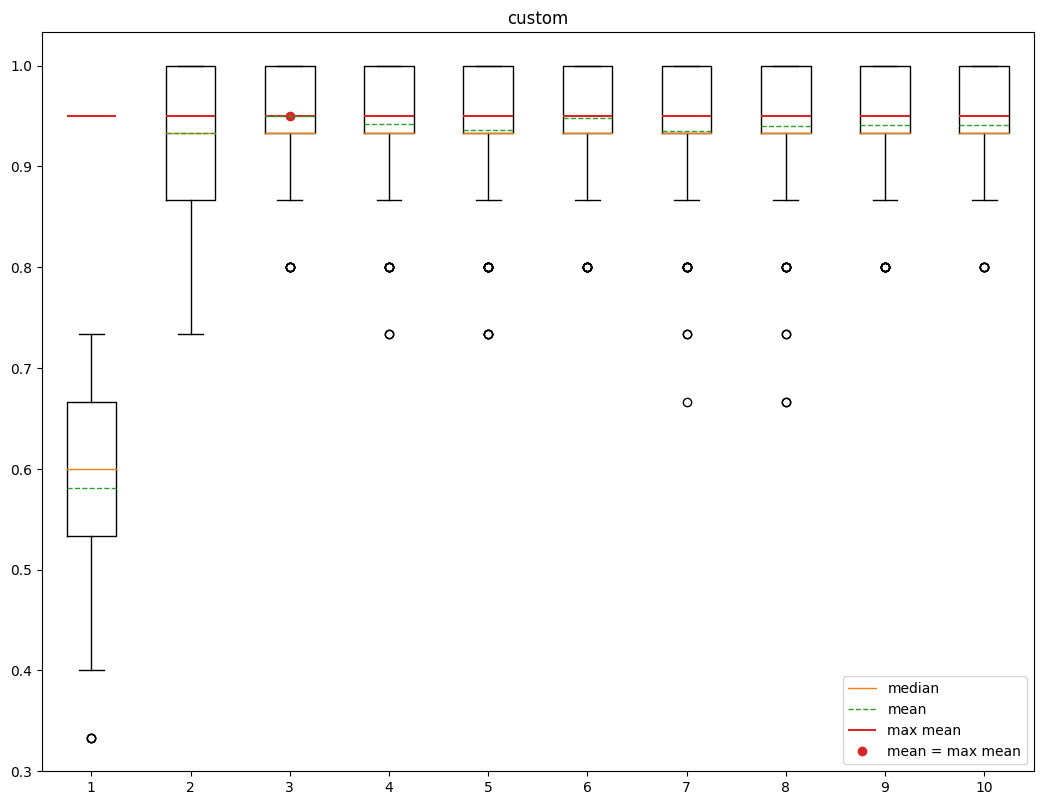

In [10]:
plot(iris, custom_classifier)

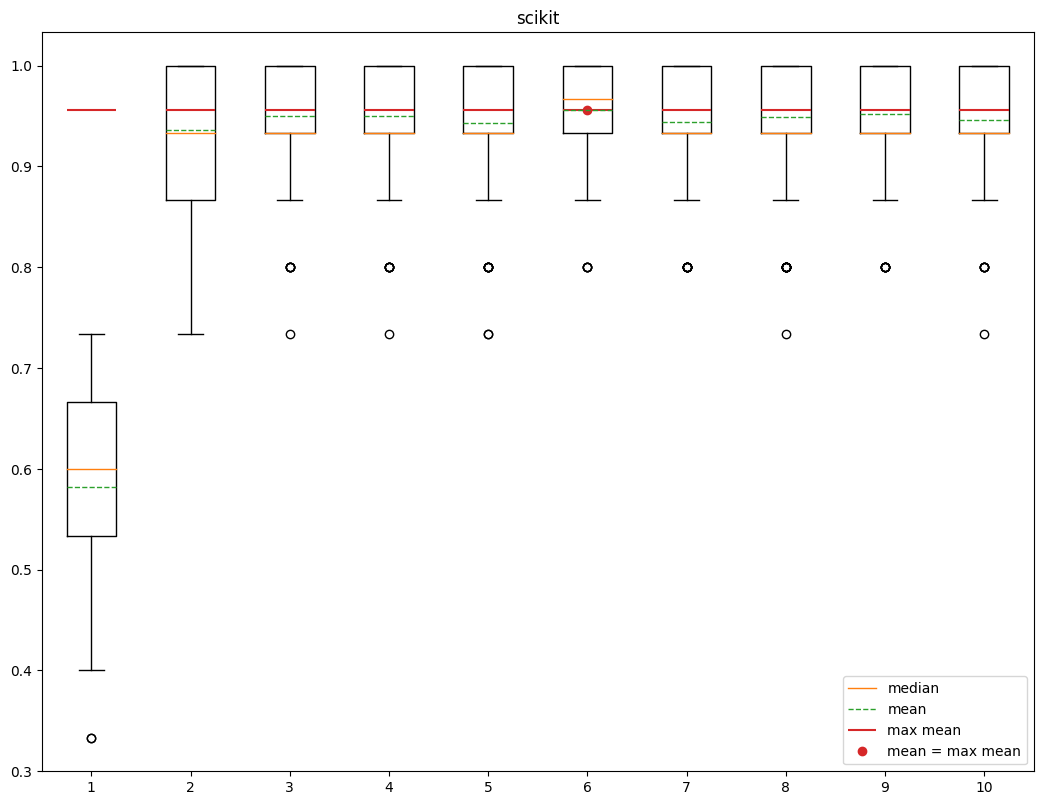

In [11]:
plot(iris, scikit_classifier)

# Wine (d=13, c=3, n=178)

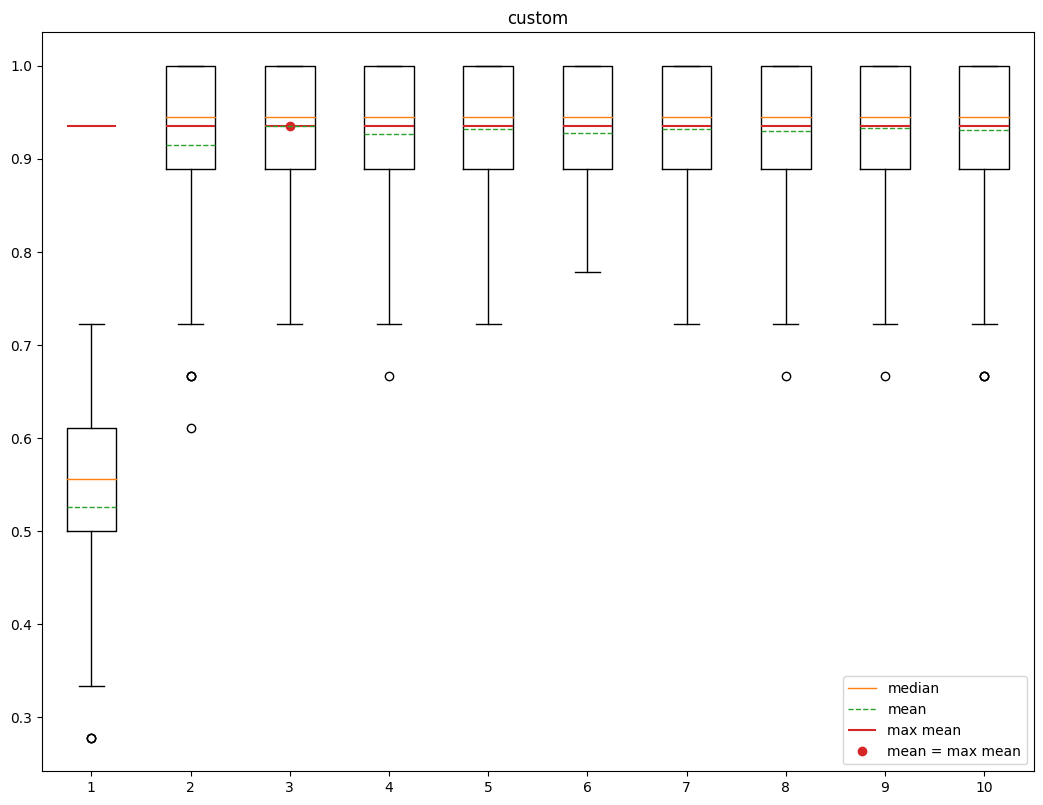

In [12]:
plot(wine, custom_classifier)

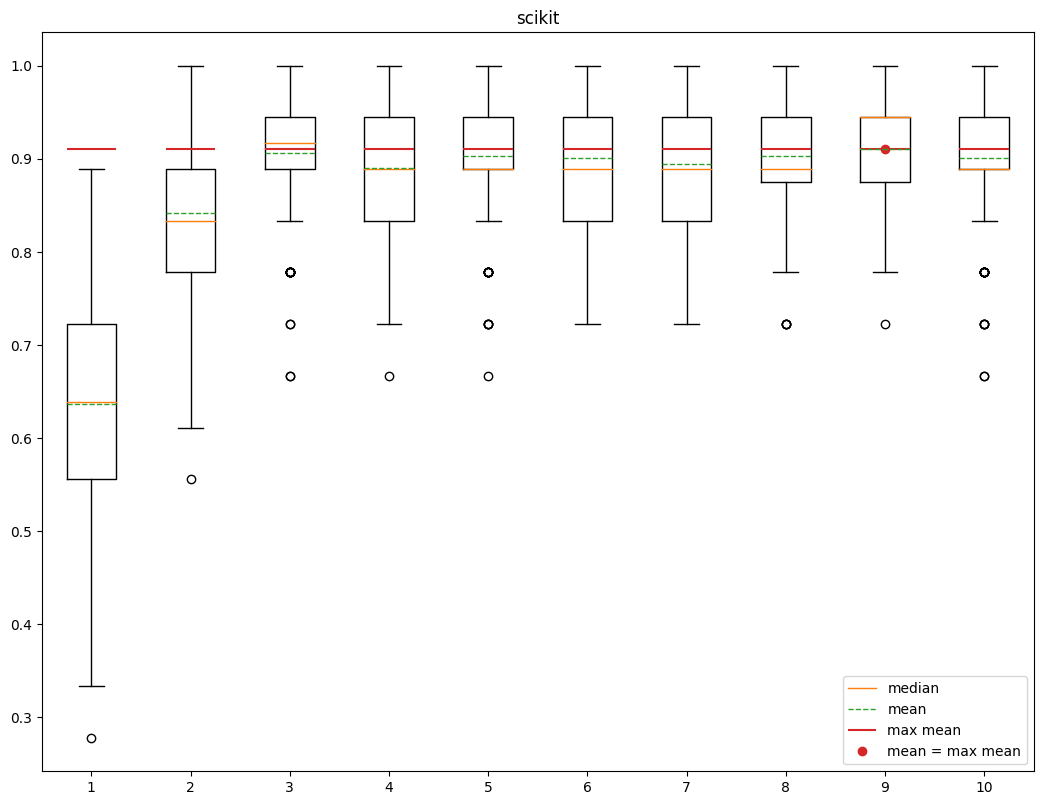

In [13]:
plot(wine, scikit_classifier)

# Digits (d=64, c=10, n=1797)

In [14]:
run_dataset(digits, custom_classifier, random_state=0, test_size=0.2)

0.8472222222222222

In [15]:
run_dataset(digits, scikit_classifier, random_state=0, test_size=0.2)

0.8638888888888889